### Import libraries

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

### Set Up GPUs

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Parameters

In [97]:
episodes = 100
gamma = 0.95 # specified by homework

# network parameters
learning_rate = 0.01
hidden_size = 10

# epochs 
epochs = 5 # will be a lot on GPUs

### Network Design

In [98]:
class PolicyGradient():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='PolicyGradient'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name='actions')
            self.expected_future_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_future_rewards")
            
            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, action_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, action_size,
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            
            # Output Layer
            self.action_distribution = tf.nn.softmax(self.fc3)
            
            self.log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.fc3, labels = self.actions_)
            self.loss = tf.reduce_mean(self.log_prob * self.expected_future_rewards_) 
            
            # adjust network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### Setup

In [99]:
tf.reset_default_graph()
network = PolicyGradient(name = 'pray4us', hidden_size=hidden_size, learning_rate=learning_rate)

In [100]:
# set up environment
env = gym.make('CartPole-v0')

# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

### Predict Future Reward Function

In [101]:
def expected_rewards(episode_rewards):
    d_episode_rewards = np.zeros_like(episode_rewards)
    future = 0.0
    for i in reversed(range(len(episode_rewards))):
        future = episode_rewards[i] + (gamma * future)
        d_episode_rewards[i] = future
        
    mean = np.mean(d_episode_rewards)
    std = np.std(d_episode_rewards)
    d_episode_rewards = (d_episode_rewards - mean) / (std)
    
    return episode_rewards

### Training

In [102]:
# saver = tf.train.Saver()
all_loss = []
all_rewards = []


with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        # save all states, actions, and rewards that happen 
        episode_states, episode_actions, episode_rewards = [], [], []
        
        for ep in range(episodes):
            state = env.reset()
            
            while True: 
            
                # get action prob distribution w.r.t. policy
                feed = {network.inputs_: state.reshape((1,*state.shape))}
                action_prob_dist = sess.run(network.action_distribution, feed_dict=feed)
                
                # select action w.r.t. distribution
                action = np.random.choice(range(action_prob_dist.shape[1]), p=action_prob_dist.ravel())
                new_state, reward, done, _ = env.step(action)
                
                # keep track of all states, actions, and rewards
                episode_states.append(state)
                episode_rewards.append(reward)
                
                # reformat action for softmax
                action_ = np.zeros(action_prob_dist.shape[1])
                action_[action] = 1
                episode_actions.append(action_)
                
                # reset current state to be new state
                state = new_state
                
                if done:

                    # Calculate discounted reward
                    exp_rewards = expected_rewards(episode_rewards)
        
                    # update the network
                    loss_, _ = sess.run([network.loss, network.learn], 
                                                feed_dict={network.inputs_: np.vstack(episode_states),
                                                network.actions_: np.vstack(episode_actions),
                                                network.expected_future_rewards_: exp_rewards })
                    
                    episode_reward_sum = np.sum(episode_rewards)
                    all_rewards.append(episode_reward_sum)
                    
                    # reset
                    episode_states, episode_actions, episode_rewards = [], [], []
                    
                    break
                    

#         if (epoch % 100 == 0):
#             saver.save(sess, "checkpoints/cartpole{0}.ckpt".format(epoch))
            

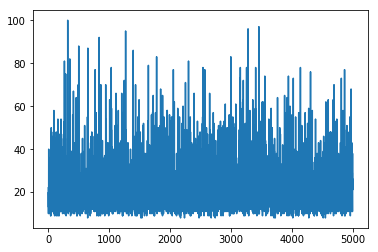

In [103]:
plt.plot(all_rewards)